In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/precog-assignment/fi.csv
/kaggle/input/precog-assignment/fi-2.csv
/kaggle/input/precog-assignment/judge_act_pre-2.csv
/kaggle/input/precog-assignment/final.csv
/kaggle/input/precog-assignment/state_time.png
/kaggle/input/precog-assignment/state_cases.png
/kaggle/input/precog-assignment/Judge_Act_merge.csv
/kaggle/input/precog-assignment/judges_clean/judges_clean.csv
/kaggle/input/precog-assignment/acts_sections/acts_sections.csv
/kaggle/input/precog-assignment/cases/cases_2015.csv
/kaggle/input/precog-assignment/cases/cases_2012.csv
/kaggle/input/precog-assignment/cases/cases_2018.csv
/kaggle/input/precog-assignment/cases/cases_2013.csv
/kaggle/input/precog-assignment/cases/cases_2017.csv
/kaggle/input/precog-assignment/cases/cases_2010.csv
/kaggle/input/precog-assignment/cases/cases_2014.csv
/kaggle/input/precog-assignment/cases/cases_2016.csv
/kaggle/input/precog-assignment/cases/cases_2011.csv
/kaggle/input/precog-assignment/keys/type_name_key.csv
/kaggle/input/precog-

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import PowerTransformer

from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from yellowbrick.classifier import ROCAUC

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import pip
!pip install bz2file
import bz2file as bz2

In [8]:
data = pd.read_csv("../input/precog-assignment/final.csv")
data.head()

,act,section,criminal,state_code,judge_position,female_judge,female_defendant,type_name,tenure,time_taken
0,8102.0,333225.0,0.0,13.0,additional chief judicial magistrate,0 nonfemale,0 male,1592.0,43,200
1,5115.0,333225.0,0.0,13.0,additional chief judicial magistrate,0 nonfemale,0 male,1592.0,138,421
2,17353.0,773491.0,1.0,7.0,chief judicial magistrate,0 nonfemale,0 male,3092.0,621,869
3,17353.0,865403.0,1.0,7.0,chief judicial magistrate,0 nonfemale,0 male,3092.0,1000,1174
4,17353.0,1140260.0,1.0,7.0,chief judicial magistrate,0 nonfemale,0 male,3092.0,441,578


In [9]:
data = data[(data["tenure"] > 0) & (data["time_taken"] > 0)] # removing spurious rows

# Data Preprocessing

### Function to label the dataset given

Here we define the classification problem. We classify the instances of the dataset into 4 groups. The labels of these groups are simply 1,2,3, and 4. 

The labels are formed based on the gender of the judge and the defendant, with 

1 -> Male judge and Male defendant

2 -> Male judge and Female defendant

3 -> Female judge and Male defendant

4 -> Female judge and Female defendant


For the rest of the notebook, the labels will be referred to as 1,2,3, and 4. 

**The goal of this classification problem is to see if given the limited features used, can we make predictions on the gender of both the judge and the defendant. Also the performance of the models will give us insights on the correlations between the features, and allow to us to somewhat confirm the analysis done in the Analysis notebooks**



In [10]:
def label(judge,defendant):
    j = int(judge.split(" ")[0])
    d = int(defendant.split(" ")[0])
    
    if(j==0 and d==0):
        return 1
    elif(j==0 and d==1):
        return 2
    elif(j==1 and d==0):
        return 3
    else:
        return 4

### Labeling the dataset

In [11]:
data["target"] = data.apply(lambda x: label(x["female_judge"],x["female_defendant"]),axis=1)
data.head()

,act,section,criminal,state_code,judge_position,female_judge,female_defendant,type_name,tenure,time_taken,target
0,8102.0,333225.0,0.0,13.0,additional chief judicial magistrate,0 nonfemale,0 male,1592.0,43,200,1
1,5115.0,333225.0,0.0,13.0,additional chief judicial magistrate,0 nonfemale,0 male,1592.0,138,421,1
2,17353.0,773491.0,1.0,7.0,chief judicial magistrate,0 nonfemale,0 male,3092.0,621,869,1
3,17353.0,865403.0,1.0,7.0,chief judicial magistrate,0 nonfemale,0 male,3092.0,1000,1174,1
4,17353.0,1140260.0,1.0,7.0,chief judicial magistrate,0 nonfemale,0 male,3092.0,441,578,1


# Selecting the required features from the dataset

In [12]:
num_attributes = ["tenure","time_taken"]
cat_attributes = ["criminal","state_code"]

In [13]:
data = data[num_attributes + cat_attributes + ["target"]]
data.head()

,tenure,time_taken,criminal,state_code,target
0,43,200,0.0,13.0,1
1,138,421,0.0,13.0,1
2,621,869,1.0,7.0,1
3,1000,1174,1.0,7.0,1
4,441,578,1.0,7.0,1


### Converting the categorical features to the 'category' datatype

In [14]:
for c in cat_attributes:
    data[c] = data[c].astype('category')

### Analysis on the label splits
Below, analysis is done to understand the distribution of the labels, so as to ensure the test and train datasets have a similar distribution to ensure the model trained gets the best results

In [15]:
data['target'].value_counts()

1    2009686
3     774003
2     239890
4      92117
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

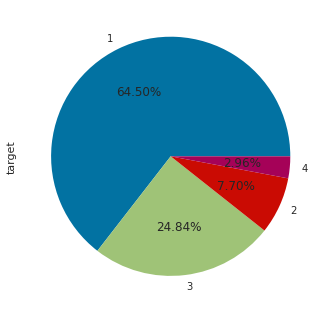

In [16]:
data['target'].value_counts().plot.pie(autopct = '%1.2f%%')

### Train-Test dataset split

In [17]:
y = data.pop('target') #Target
X = data  #DataFrame with features

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=10)
print(y_train.value_counts())
print(y_test.value_counts())

1    1507089
3     580443
2     179910
4      69330
Name: target, dtype: int64
1    502597
3    193560
2     59980
4     22787
Name: target, dtype: int64


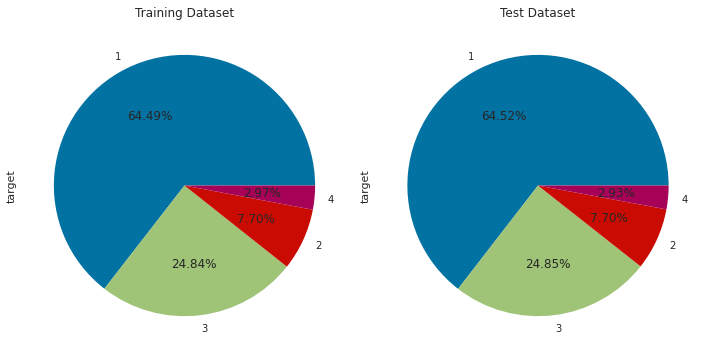

In [18]:
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
y_train.value_counts().plot.pie(autopct = '%1.2f%%')
plt.title('Training Dataset')

plt.subplot(1,2,2)
y_test.value_counts().plot.pie(autopct = '%1.2f%%')
plt.title('Test Dataset')

plt.tight_layout()

### Label distribution analysis results

Here we can see that by using the `train_test_split` method from the sklearn library the distribution of the labels in both the train and the test dataset are similar to each other and the to the distribution of labels in the overall dataset. 

If this was not the case we have had to use alternate methods to get the train-test split, such as the `StratifiedShuffleSplit` method from Sklearn, that ensures that the distribution of labels is maintained

### Data Transformations

Before providing our dataset to the ML models, we have to make certain transformations to the data. We first OneHotEncode the categorical data, as the ML model works with numbers and cannot work with categorical values. 

Next, we perform the `PowerTransformer` method the numerical attributes in order to make the numerical values more gaussian like

In [19]:
final_df = pd.get_dummies(X_train) ## OneHotEncoding
for c in num_attributes:
    pt = PowerTransformer()
    final_df.loc[:, c] = pt.fit_transform(np.array(final_df[c]).reshape(-1, 1))

In [20]:
final_df.head()

,tenure,time_taken,criminal_0.0,criminal_1.0,state_code_1.0,state_code_2.0,state_code_3.0,state_code_4.0,state_code_5.0,state_code_6.0,...,state_code_20.0,state_code_21.0,state_code_22.0,state_code_23.0,state_code_24.0,state_code_25.0,state_code_26.0,state_code_27.0,state_code_29.0,state_code_30.0
2900703,-0.389451,0.476947,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3477835,-0.280864,0.512760,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
242510,-0.630440,-0.305402,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1542406,-0.684267,0.481812,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830597,1.964959,-0.939863,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Models

### Models that are to be tested

In [21]:
ovo_c = OneVsOneClassifier(SGDClassifier(random_state=42))
rf_c = RandomForestClassifier()

### Transforming the test dataset

In [22]:
test_df = pd.get_dummies(X_test)
for c in num_attributes:
    pt = PowerTransformer()
    test_df.loc[:, c] = pt.fit_transform(np.array(test_df[c]).reshape(-1, 1))

### Function to train the model, fit it with the training data and then measure its performance on the test data, and plot the corresponding ROC curve

When checking the performance of classification models on datasets with a class imbalance,i.e with the no of each class being unequal (check above for the label distribution analysis), accuracy can be a misleading metric. 

One of the ways to measure of the performance of the model in such cases, is by plotting an ROC Curve. It plots True Positive Rate vs False Positive Rate. The area under the curve will gove us how much the model is able to distinuguish between the positive and the negative class for each label.

This information gives us a better measure for the performance of the model.

We also plot the cofusion matrix produced by both models and also give the classification report for each model

In [23]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    visualizer = ROCAUC(model, encoder={1: '1', 
                                        2: '2', 
                                        3: '3',
                                        4: '4'})
                                                                         
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

# Peformance Measure for the OneVsOne Classifier

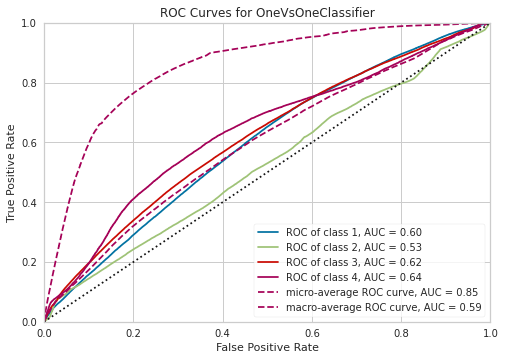

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for OneVsOneClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4'},
       estimator=OneVsOneClassifier(estimator=SGDClassifier(random_state=42)))

In [24]:
plot_ROC_curve(ovo_c,final_df,y_train,test_df,y_test)

In [25]:
ovo_c.fit(final_df,y_train)
pred_o = ovo_c.predict(test_df)

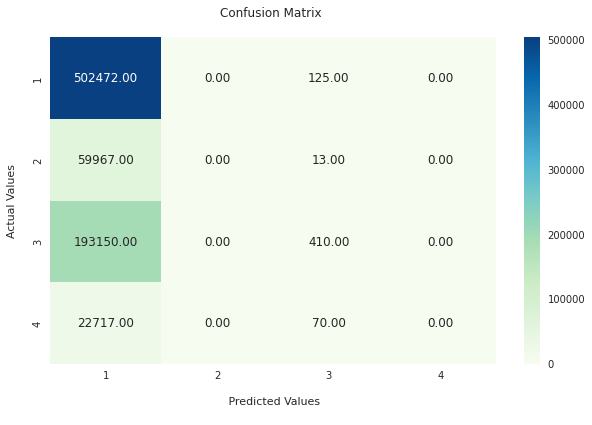

In [26]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,pred_o), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['1','2','3','4'])
fx.yaxis.set_ticklabels(['1','2','3','4'])
plt.show()

In [27]:
print(classification_report(y_test, pred_o))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.65      1.00      0.78    502597
           2       0.00      0.00      0.00     59980
           3       0.66      0.00      0.00    193560
           4       0.00      0.00      0.00     22787

    accuracy                           0.65    778924
   macro avg       0.33      0.25      0.20    778924
weighted avg       0.58      0.65      0.51    778924



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Performance Measure Analysis

From the above metrics and visualizations, we can see that this model has performed very poorly with this classification problem. 

**ROC curve:**
The given ROC curve is plotted as one against all for each label. The curve shows that there is a pretty significant overlap in the regions of positove and negative classes for all labels, with the label 2 being pretty significantly poor, having AUC of close to 50. 

**Classification report:**
From the classsification report we can see that the precision,recall and F1 score is pretty poor for every label apart from the label 1. Further anlysis of label's 1 statistics are more telling.

It seems that model for the most part has blindly labelled every instance as belonging to label 1. This can be inferred from the fact that label 1 has a recall of 1, and an precision of 0.65 which is approximately the fraction of label 1 instances that exist in the dataset(check above for the label distribution analysis). Also, the recall of and precision of classes 2 and 4 are zero, which further solidifies this inference.

This almost blind labelling of the instances also explians the accuracy of the model being 0.65 which again is approximately the ratio of the Label 1 instances in the dataset.

# Performance Measure for the RandomForest Classifier

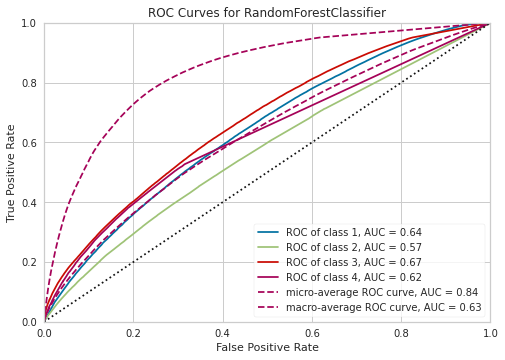

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4'},
       estimator=RandomForestClassifier())

In [28]:
plot_ROC_curve(rf_c,final_df,y_train,test_df,y_test)

In [29]:
rf_c.fit(final_df,y_train)
pred_r = rf_c.predict(test_df)

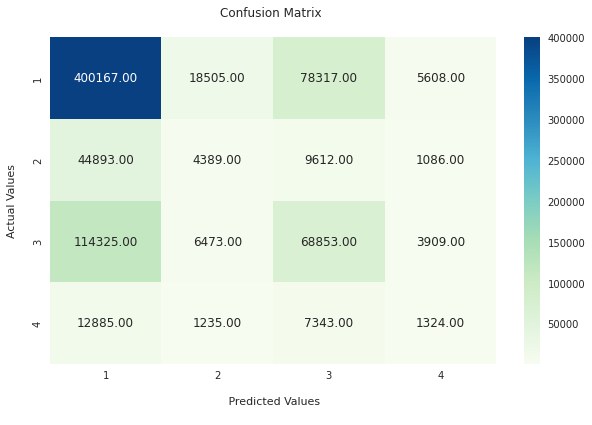

In [30]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,pred_r), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['1','2','3','4'])
fx.yaxis.set_ticklabels(['1','2','3','4'])
plt.show()

In [31]:
print(classification_report(y_test, pred_r))

              precision    recall  f1-score   support

           1       0.70      0.80      0.74    502597
           2       0.14      0.07      0.10     59980
           3       0.42      0.36      0.38    193560
           4       0.11      0.06      0.08     22787

    accuracy                           0.61    778924
   macro avg       0.34      0.32      0.33    778924
weighted avg       0.57      0.61      0.59    778924



### Performance Measure Analysis

From the above performance metrics we can see the while the performnace of this model is far from ideal, it does show some improvement from the previous model.

**ROC Curve:** 
From the ROC curve we an see while there is a large amount of overlapof the positive and negative classes fo reach label, the AUC curve is higher for each label than compared to the OneVsOne Classifier. This shows that the some learning is being done by the model, and it is drawing on some correlations between the features, and the assigned labels.

**Classification Report:** 
The classification report and the confusion matrix show a similar trend. While the scores
for Label 1 have decreased, scores for the other 3 labels have increased, showing that the Random Forest model is better at distinguishing between positive and negative instances for each class.

So even though the accuracy of this model is lower than that of the OneVsOne model, it is clear that it has the learned more from the dataset, and is a better classification tool.

## Saving the Model
### Here we save the best performing model which in this case is the Random Forest Classifier

In [33]:
def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        pickle.dump(data, f)

In [34]:
compressed_pickle("../working/random_forest_gen",rf_c)

In [36]:
os.chdir(r'/kaggle/working')
!tar -zcvf outputname.tar.gz /kaggle/working

from IPython.display import FileLink
FileLink(r'outputname.tar.gz')

tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/.virtual_documents/
/kaggle/working/random_forest_gen.pbz2
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/outputname.tar.gz
tar: /kaggle/working/outputname.tar.gz: file changed as we read it


/kaggle/working/outputname.tar.gz

# Insights
From the results of the classification problem, and its analysis, we can gleam the following insights:

1. The performance model shows us that there is some correlation between the provided features and the genders of both the judge and the defendant given.

2. While the model shows us that there is some correlation, the performance of the models were far from ideal and tells us that while the features do show some correlation, more information is needed for better analysis and results

3. From the first point we can infer that the analysis done in the Analysis notebooks in this project were in the right direction, drawing on the correlation between these features
